In [27]:
import sys
import os
import random
os.nice(10)
os.environ["OPENBLAS_NUM_THREADS"] = "10"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import astra
import numpy as np
import pydicom 
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [106]:
#define the astra projection function 

def astra_project(file_list, n_projections, savedir):
    
    """
    Forward and backproject CT images with a specified number of projections. 
    Saves the output in the specified savedir folder with the same filename as the original file.
    
    Parameters
    
    -----------------

    file_list : list of strings
        list of filenames which shall be processed
    n_projections : int
        number of projections to be used for the reconstruction
    savedir : str
        directory where the output files are saved
    """
    
    #define geometry
    geometry = 'parallel'
    pixel_spacing = 1
    n_detectors = 768

    #iterate through list
    for i, file in enumerate(file_list):
        sys.stdout.write('\r'+f'{i}/{len(file_list)}')
        
        #load file
        pyd = pydicom.dcmread(file)        
 
        #setup geometries
        vol_geom = astra.create_vol_geom(512, 512)
        proj_geom = astra.create_proj_geom(geometry, pixel_spacing, n_detectors, np.linspace(0,2*np.pi,n_projections,False))

        proj_id = astra.create_projector('cuda', proj_geom,vol_geom)
        data = (pyd.RescaleSlope*pyd.pixel_array + pyd.RescaleIntercept + 1024)/4095

        if data.shape == (512, 512):
            sinogram_id, sinogram = astra.create_sino(data, proj_id, returnData=True, gpuIndex=0)

            # Create a data object for the reconstruction

            rec_id = astra.data2d.create('-vol', vol_geom)
            
            # create configuration
            cfg = astra.astra_dict('FBP_CUDA')
            cfg['ReconstructionDataId'] = rec_id
            cfg['ProjectionDataId'] = sinogram_id
            cfg['option'] = {'FilterType': 'Ram-Lak'}
            alg_id = astra.algorithm.create(cfg)
            astra.algorithm.run(alg_id)
            rec = astra.data2d.get(rec_id)
        
            # Clean up.
            astra.algorithm.delete(alg_id)
            astra.data2d.delete(rec_id)
            astra.data2d.delete(sinogram_id)
            
            #save data
            name = os.path.splitext(os.path.basename(file))[0]
            savepath = savedir + f'/{angle}/'
            if not os.path.isdir(savepath):
                os.makedirs(savepath)
                print("\ncreated folder: ", savepath)
            np.save(savepath + f'{name}.npy', rec.astype('float16'))
        else:
            print('invalid shape, skip this image')
            
    astra.projector.delete(proj_id)
    
    return data, sinogram, rec

In [112]:
#make sure that the base dicom files are located in ./Data/stage_2_train/
#specify parameters
file_list = glob.glob(os.path.abspath("./Data/stage_2_train/*"))
save_dir = os.path.abspath("./Data/")
angles = [4096, 2048, 1024, 512, 256, 128, 64]

In [113]:
#create data
for angle in angles:
    print("\n", angle)
    data, sino, rec = astra_project(file_list, angle, save_dir)


 4096
19/20
 2048
19/20
 1024
19/20
 512
19/20
 256
19/20
 128
19/20
 64
19/20

ID_000012eaf.npy


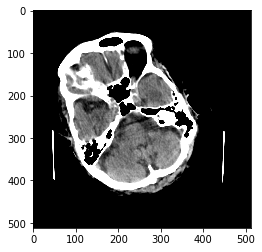

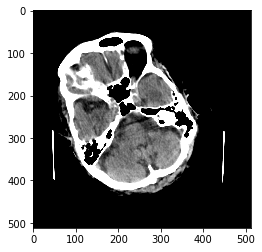

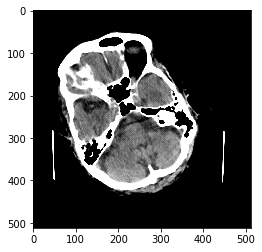

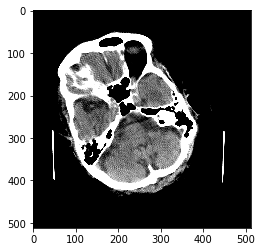

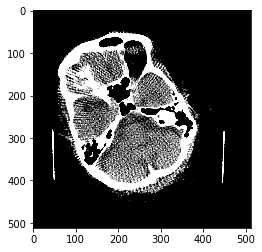

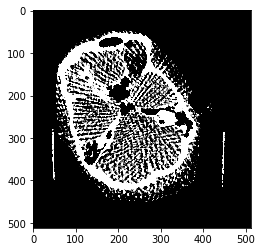

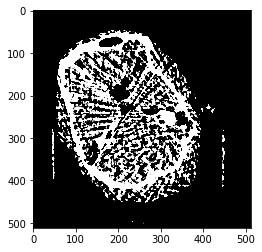

In [114]:
#check results

name = os.listdir(save_dir + "/4096/")[0]
print(name)
for angle in angles:
    img = np.load(f"{save_dir}/{angle}/{name}")
    plt.figure(f"{angle}")
    plt.imshow(img*4095-1024, vmin=0, vmax=80, cmap='gray')